In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

In [119]:
start_date = '2021-01-01'
end_date = '2022-12-31'
# period = '252d'
period = '2540d'
frequency = '1d'

In [120]:
# stock_1 = yf.download('AMD', start=start_date, end=end_date, interval=frequency)
# stock_2 = yf.download('NVDA', start=start_date, end=end_date, interval=frequency)
stock1_name = 'NKE'
stock2_name = 'SBUX'
stock_1 = yf.download(stock1_name, period=period, interval=frequency)[0:1260]
stock_2 = yf.download(stock2_name, period=period, interval=frequency)[0:1260]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[]

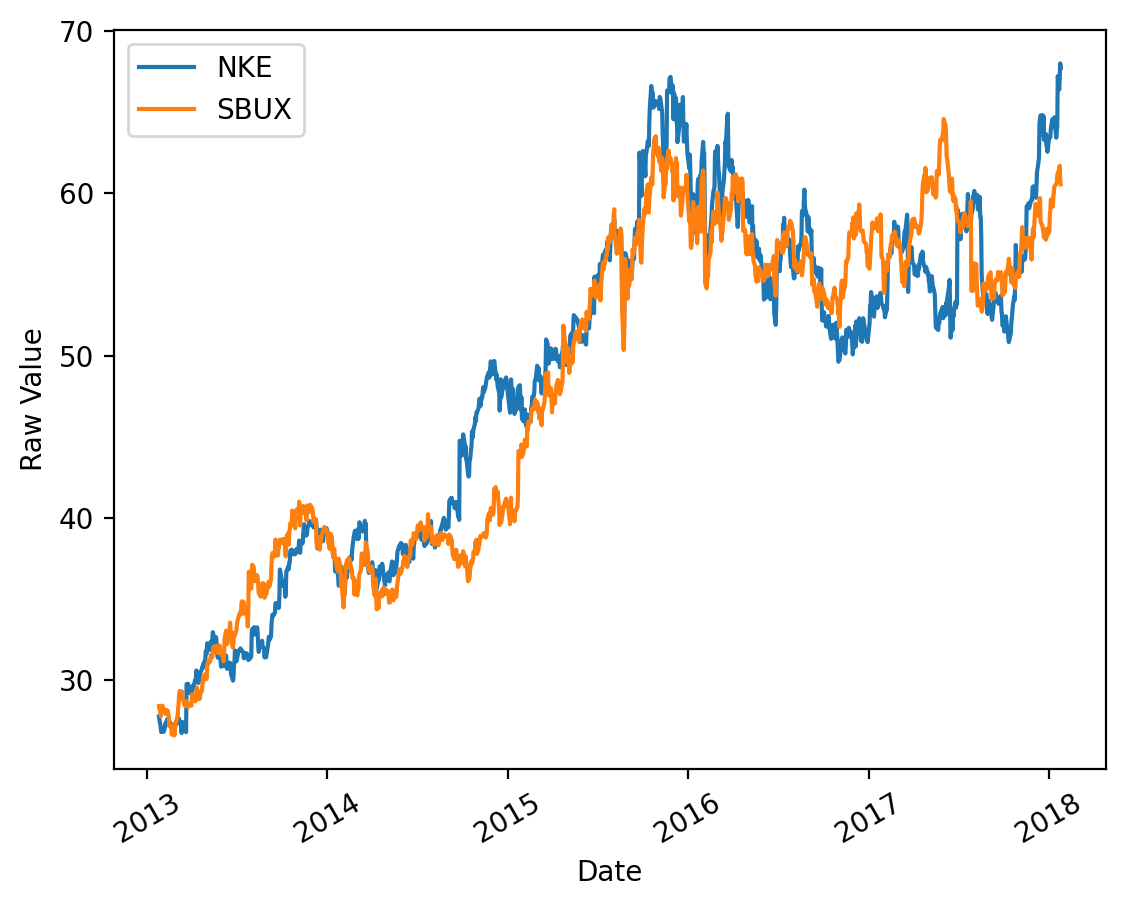

In [122]:
plt.figure(dpi=200)
plt.plot(stock_1.index, stock_1['Close'])
plt.plot(stock_1.index, stock_2['Close'])
# plt.axhline(y = 30, color = 'r', linestyle = '-')
# plt.axvline(x = 30, color = 'r', linestyle = '-')
# plt.axvline(x = 0, color = 'r', linestyle = '-')
plt.legend([stock1_name, stock2_name])
plt.xlabel('Date')
plt.ylabel('Raw Value')
plt.xticks(rotation=30)
plt.plot()

# MLE Approach

In [123]:
# Combine prices into a DataFrame
prices = pd.DataFrame(index=stock_1.index)
prices[stock1_name] = stock_1['Close']
prices[stock2_name] = stock_2['Close']
prices[f'{stock1_name}_normalized'] = stock_1['Close']/stock_1['Close'].iloc[0]
prices[f'{stock2_name}_normalized'] = stock_2['Close']/stock_2['Close'].iloc[0]

# Calculate the spread between the two stocks
# spread = prices['CMS'] - prices['DUK']

In [124]:
S = np.matrix(prices[[f'{stock1_name}_normalized',f'{stock1_name}_normalized']])

In [125]:
def magnitude(x):
#     return np.sqrt(np.dot(x,x.T))
    return np.linalg.norm(x)**2

# def neg_log_likelihood(params, S):
#     theta, mu, sigma, weights = params
#     n = S.shape[0]-1
#     diff = np.diff(x - mu)
#     sigma_sq = sigma ** 2
#     sigma_sq_est = sigma*(1-np.exp(-n*mu))/(2*mu)
#     neg_ll = 0.5*np.log(2*np.pi) + 0.5*np.log(sigma_sq_est*) - 0.5 * np.sum(diff ** 2) / sigma_sq \
#          - (n - 1) * np.log(1 - np.exp(-2 * theta))
# #     return -log_likelihood(params, x)

def neg_log_likelihood(params, S):
    mu, theta, sigma, alpha, beta, r = params
    w = np.matrix([alpha,beta]).T
    T = S.shape[0]-1
    diff = np.diff(S - mu)
    sigma_sq = sigma ** 2
    a = sigma_sq*(1-np.exp((-2/(T+1))*mu))/(2*mu)
    c = np.exp((-1/(T+1))*mu)
    A = S[1:T+1] - c*S[0:T]
#     print(magnitude(A*w-theta*(1-c)))
    neg_ll = 0.5*np.log(a)+(1/(2*T*a))*magnitude(A*w-theta*(1-c))+r*c
    return neg_ll

def neg_log_likelihood2(params, x):
    mu, theta, sigma = params
    sigma_sq = sigma ** 2
    n = S.shape[0]
    delta_t = 1 / (n-1)
#     a = sigma_sq*(1-np.exp((-2/(T+1))*mu))/(2*mu)
#     c = np.exp((-1/(T+1))*mu)
#     A = S[1:T+1] - c*S[0:T]
    sigma_sq_est = sigma_sq*(1-np.exp(-2*mu*delta_t))/(2*mu)
    part = 0
    for i in range(1,n):
        sub = x[i]-x[i-1]*np.exp(-mu*delta_t)-theta*(1-np.exp(-mu*delta_t))
        part += (sub)**2
    ll = -0.5*np.log(2*np.pi)-np.log(sigma_sq_est)-(1/(2*n*sigma_sq_est))*part
    return -ll

def neg_log_likelihood3(params, S):
    mu, theta, sigma, beta = params
    w = np.matrix([1,-beta]).T
    x = S*w
    sigma_sq = sigma ** 2
    n = S.shape[0]
    delta_t = 1 / n
#     a = sigma_sq*(1-np.exp((-2/(T+1))*mu))/(2*mu)
#     c = np.exp((-1/(T+1))*mu)
#     A = S[1:T+1] - c*S[0:T]
    sigma_sq_est = sigma_sq*(1-np.exp(-2*mu*delta_t))/(2*mu)
    part = 0
    for i in range(1,n):
        sub = x[i]-x[i-1]*np.exp(-mu*delta_t)-theta*(1-np.exp(-mu*delta_t))
        part += (sub)**2
    ll = -0.5*np.log(2*np.pi)-np.log(sigma_sq_est)-(1/(2*n*sigma_sq_est))*part
    return -ll

def constraint(x):
    mu, theta, sigma, alpha, beta, r = x
    return np.linalg.norm(np.matrix([alpha,beta]).T, ord=1)-1

def constraint2(x, eta):
    mu, theta, sigma, alpha, beta, r = x
    count = 0
    if alpha > 0:
        count += 1
    if beta > 0:
        count += 1
    return count-eta

def constraint3(x):
    mu, theta, sigma, beta = x
    if beta <= 0 or beta > 1:
        return -1
    else:
        return 0

In [126]:
def MLE(X):
#     bounds = ((None, None), (1e-5, None), (1e-5, None))  # theta ∈ ℝ, mu > 0, sigma > 0
#                                                            # we need 1e-10 b/c scipy bounds are inclusive of 0, 
#                                                            # and sigma = 0 causes division by 0 error
    theta_init = np.mean(X)
    mu_init = 100
    sigma_init = np.std(X)
    params0 = (mu_init, theta_init, sigma_init)
    result = minimize(neg_log_likelihood2, params0, args=(X,))
    mu, theta, sigma = result.x
    max_log_likelihood = -result.fun  # undo negation from __compute_log_likelihood
    # .x gets the optimized parameters, .fun gets the optimized value
    return theta, mu, sigma, max_log_likelihood

In [139]:
def compute_portfolio_values(ts_A, ts_B, alloc_B):
    ts_A = ts_A.copy()  # defensive programming
    ts_B = ts_B.copy()
    
    ts_A = ts_A / ts_A[0]
    ts_B = ts_B / ts_B[0]
    
    result = ts_A - alloc_B * ts_B
    
#     if alloc_B > (1-alloc_B):
#         result = -result
    return result

In [140]:
def arg_max_B_alloc(ts_A, ts_B):   
    theta = mu = sigma = alloc_B = 0
    max_log_likelihood = 0

    def compute_coefficients(x):
        portfolio_values = compute_portfolio_values(ts_A, ts_B, x)
        return MLE(portfolio_values)
    
    vectorized = np.vectorize(compute_coefficients)
    linspace = np.linspace(.01, 1, 100)
    res = vectorized(linspace)
    index = res[3].argmax()
    
    return res[0][index], res[1][index], res[2][index], linspace[index]

In [135]:
theta, mu, sigma, b_alloc = arg_max_B_alloc(stock_1['Close'], stock_2['Close'])

In [136]:
theta, mu, sigma, b_alloc

(59.618585497232004, 3.0059343481506295, 17.1083165036915, 1.0)

In [98]:
x = compute_portfolio_values(stock_1['Close'], stock_2['Close'], b_alloc)
x

Date
2022-02-24   -0.100000
2022-02-25   -0.102285
2022-02-28   -0.107504
2022-03-01   -0.120605
2022-03-02   -0.126550
                ...   
2023-02-17   -0.199123
2023-02-21   -0.191238
2023-02-22   -0.192179
2023-02-23   -0.195253
2023-02-24   -0.196363
Name: Close, Length: 252, dtype: float64

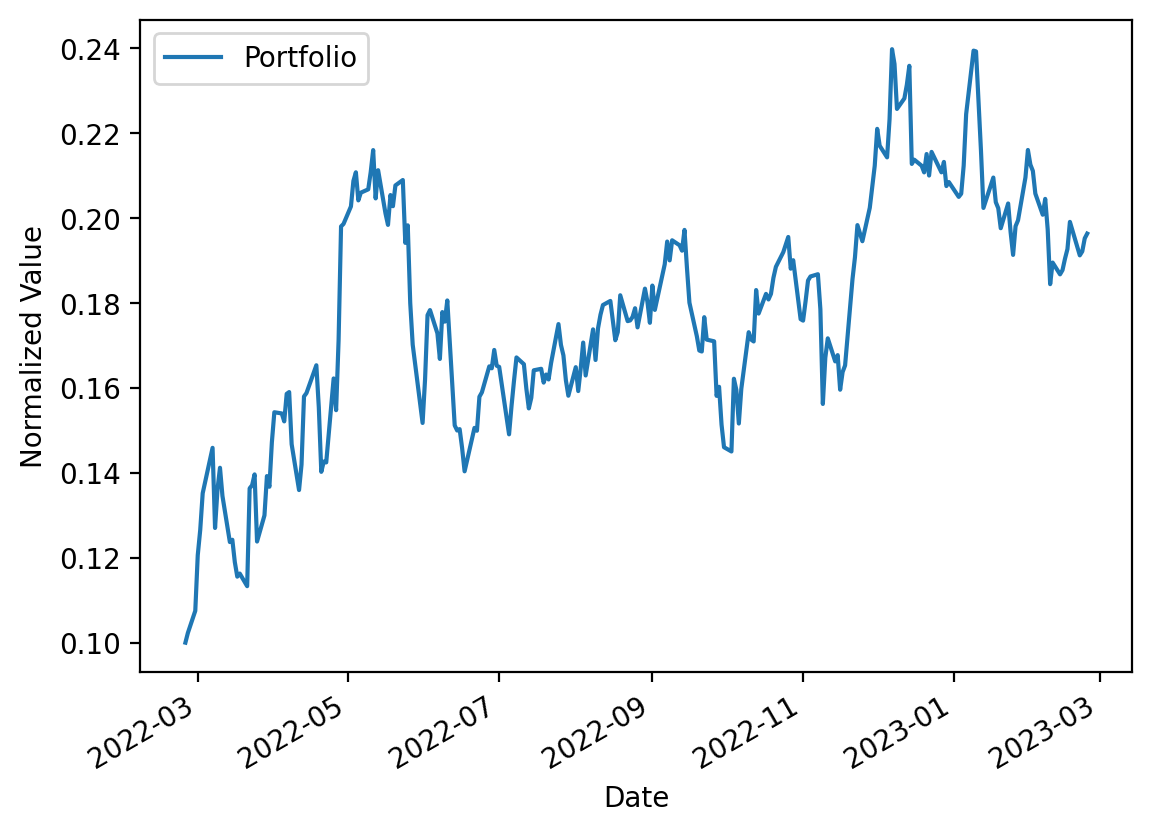

In [40]:
plt.figure(dpi=200) 
x.plot(ylabel='Normalized Value')
plt.xticks(rotation=30)
plt.legend(['Portfolio'])
# plt.ylabel('Normalized Value')

[]

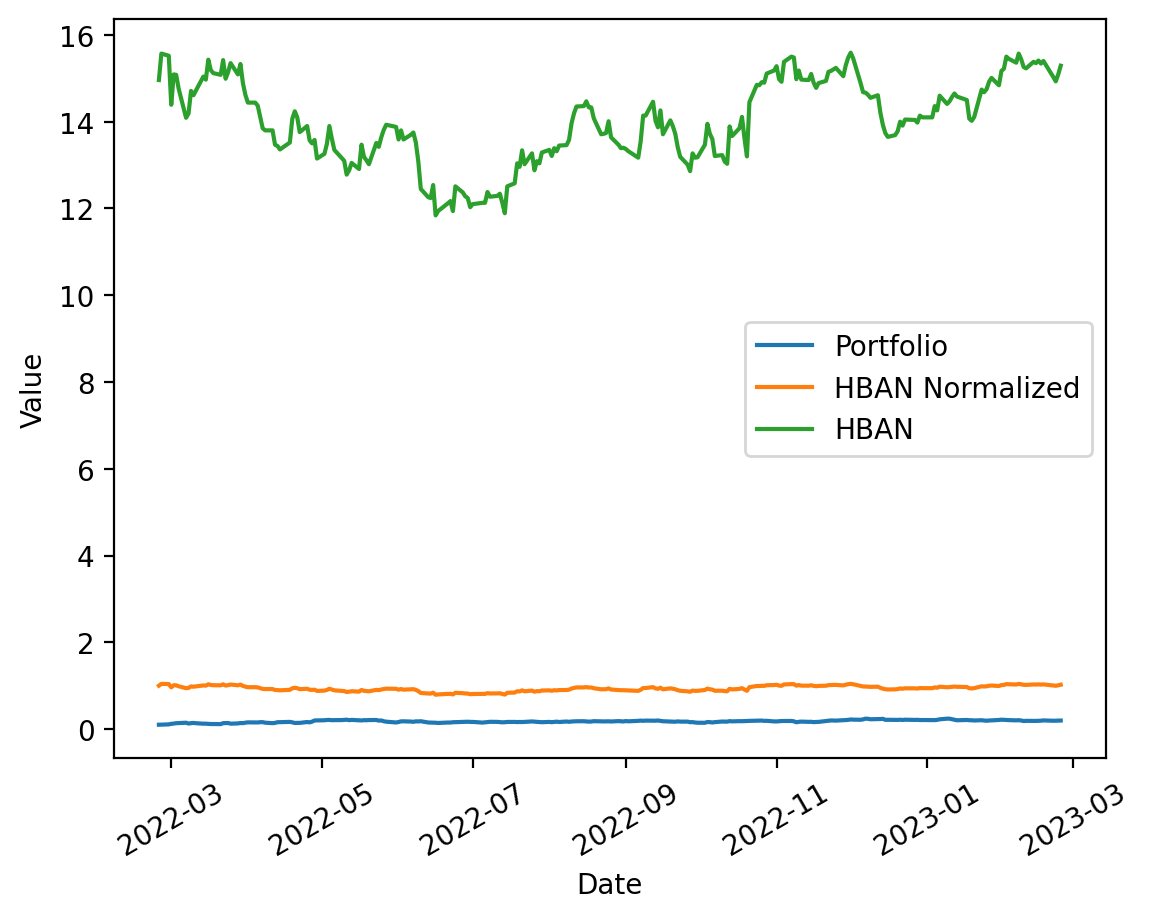

In [64]:
plt.figure(dpi=200) 
normalized_1 = stock_1['Close']/stock_1['Close'].iloc[0]
normalized_2 = stock_2['Close']/stock_2['Close'].iloc[0]
plt.plot(x.index, x.values)
plt.plot(x.index, normalized_1)
plt.plot(x.index, stock_1['Close'])
plt.legend(['Portfolio',f'{stock1_name} Normalized', stock1_name])
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=30)
plt.plot()

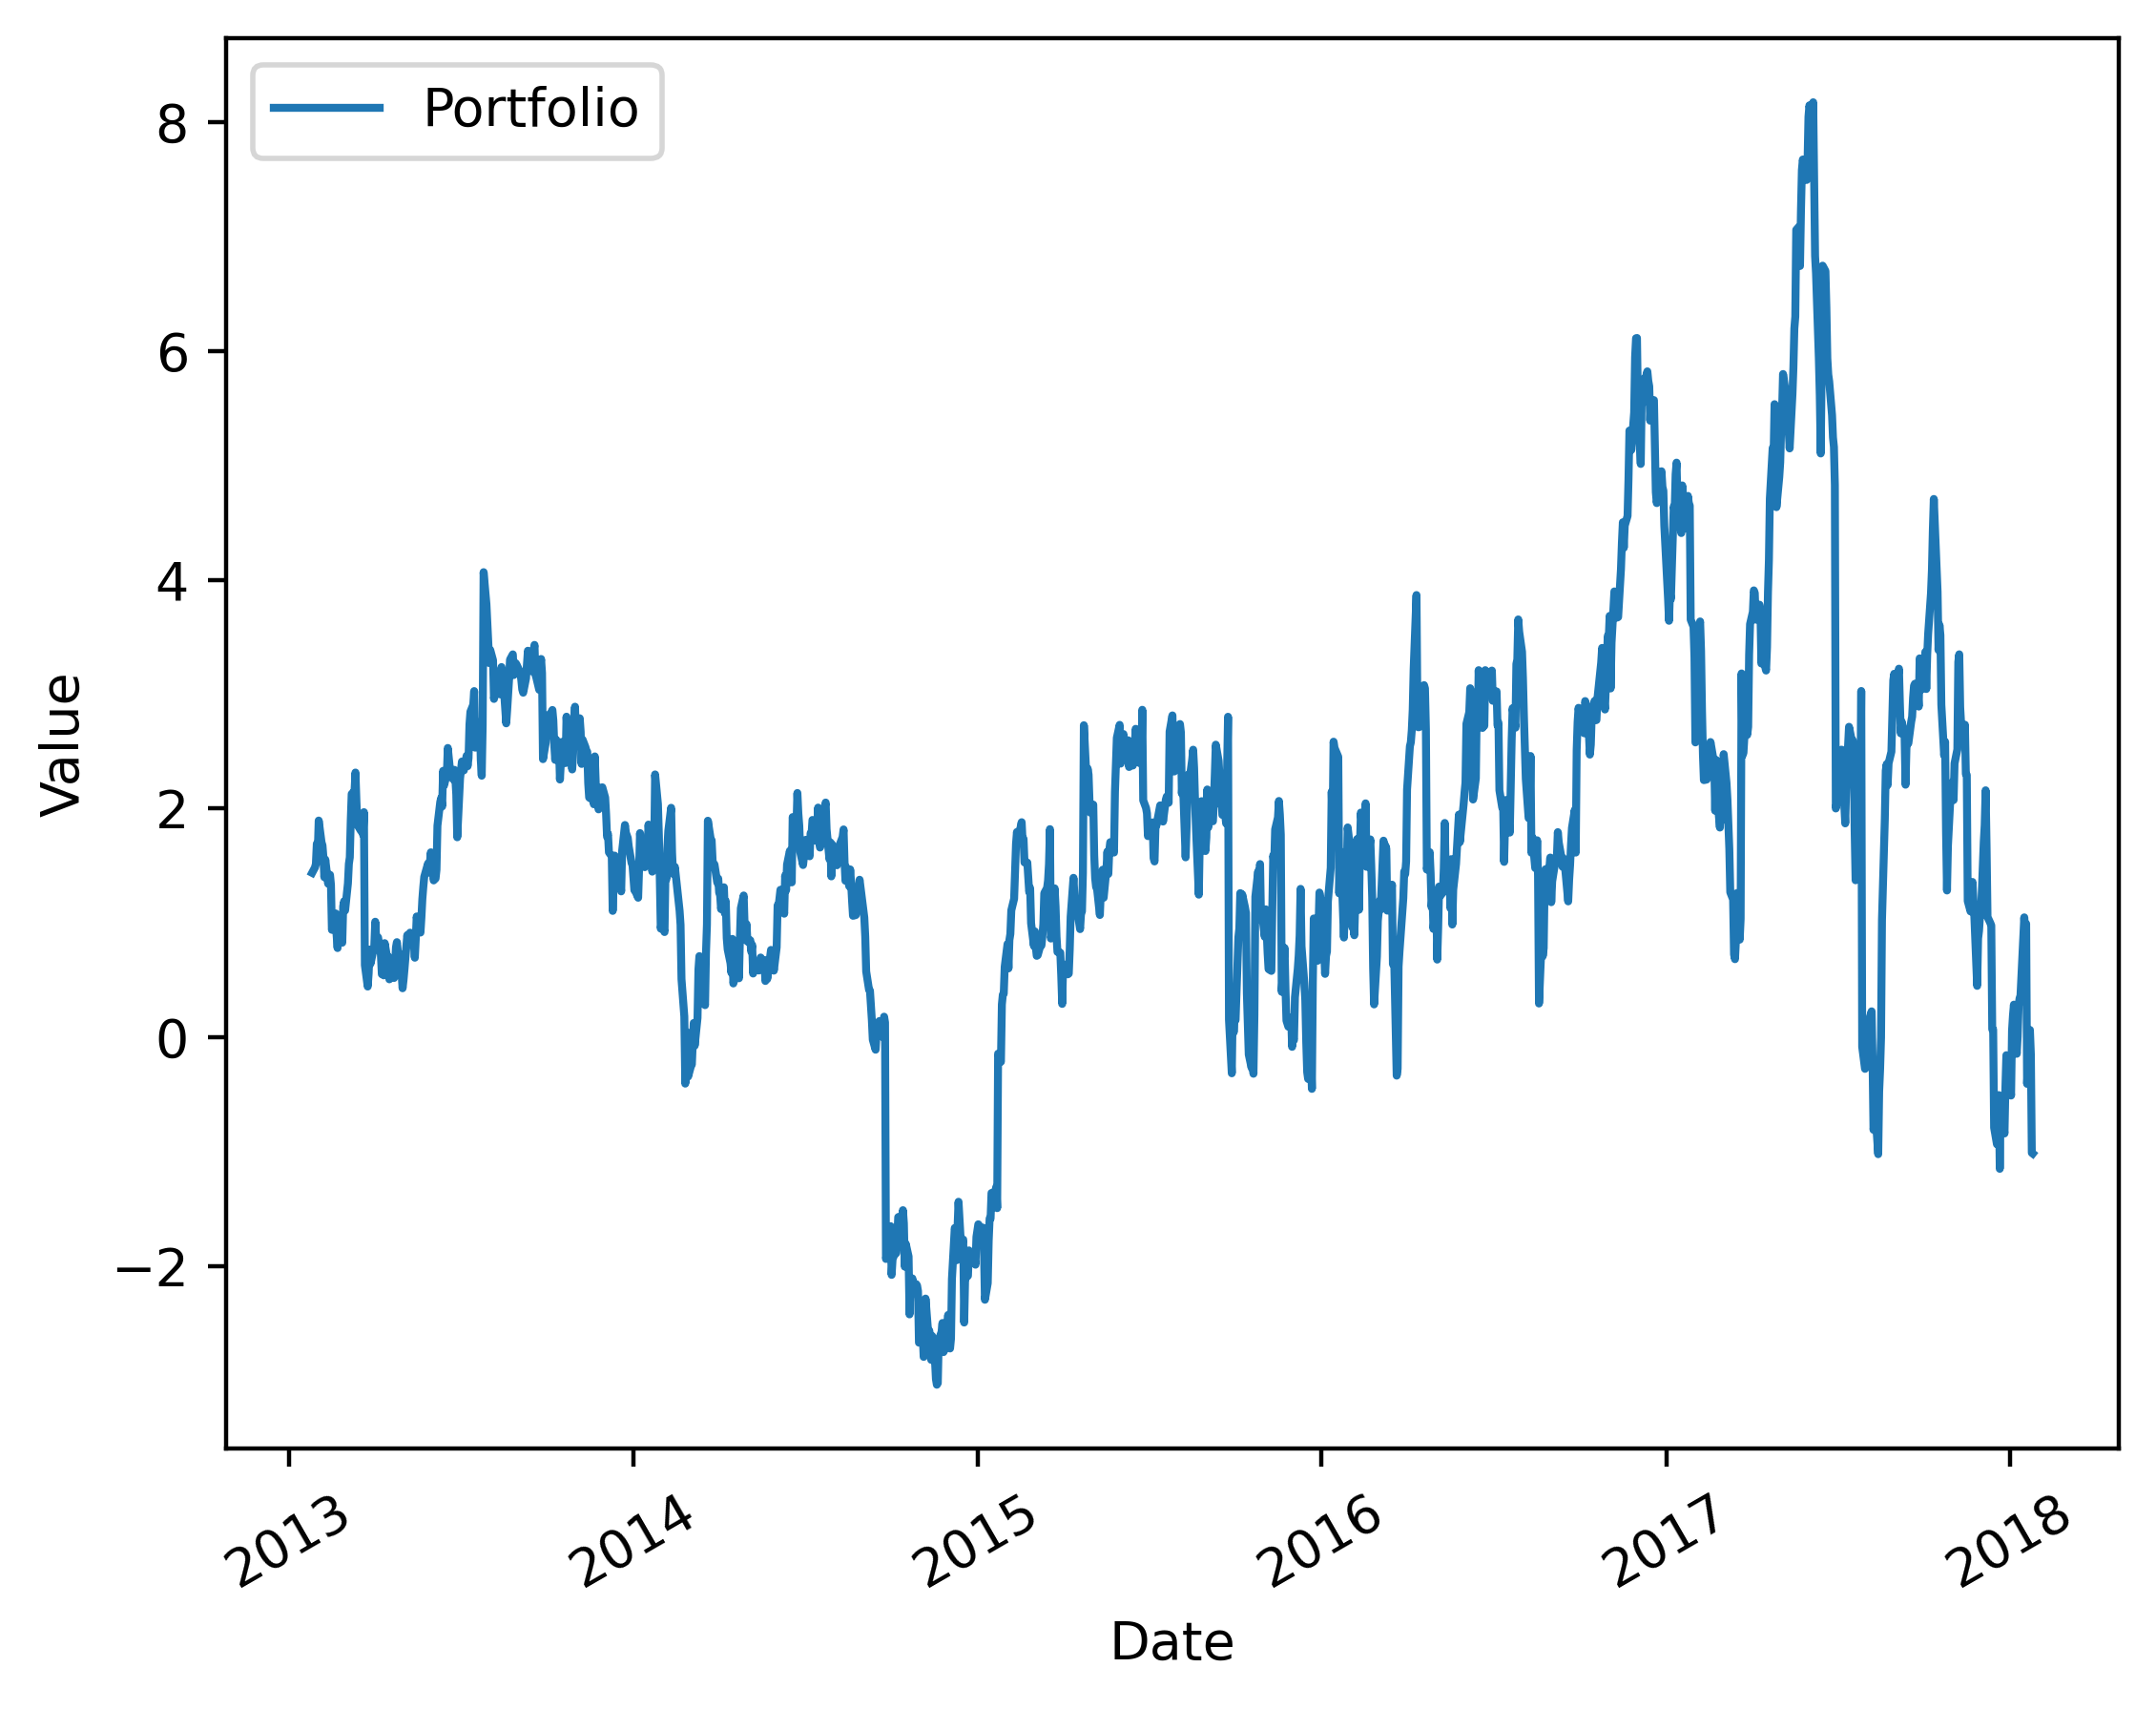

In [131]:
x3 = (1-b_alloc)*stock_1['Close'] - b_alloc * stock_2['Close']

# x3 = (1/stock_1['Close'].iloc[0])*stock_1['Close'] - (b_alloc/stock_2['Close'].iloc[0]) * stock_2['Close']
# x3 = (1*(1-b_alloc)/stock_1['Close'].iloc[0])*stock_1['Close'] - (1*b_alloc/stock_2['Close'].iloc[0]) * stock_2['Close']
if b_alloc > (1-b_alloc):
    x3 = -x3
plt.figure(dpi=400) 
plt.plot(x3.index, x3.values)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Portfolio'])
plt.xticks(rotation=30)
plt.show()

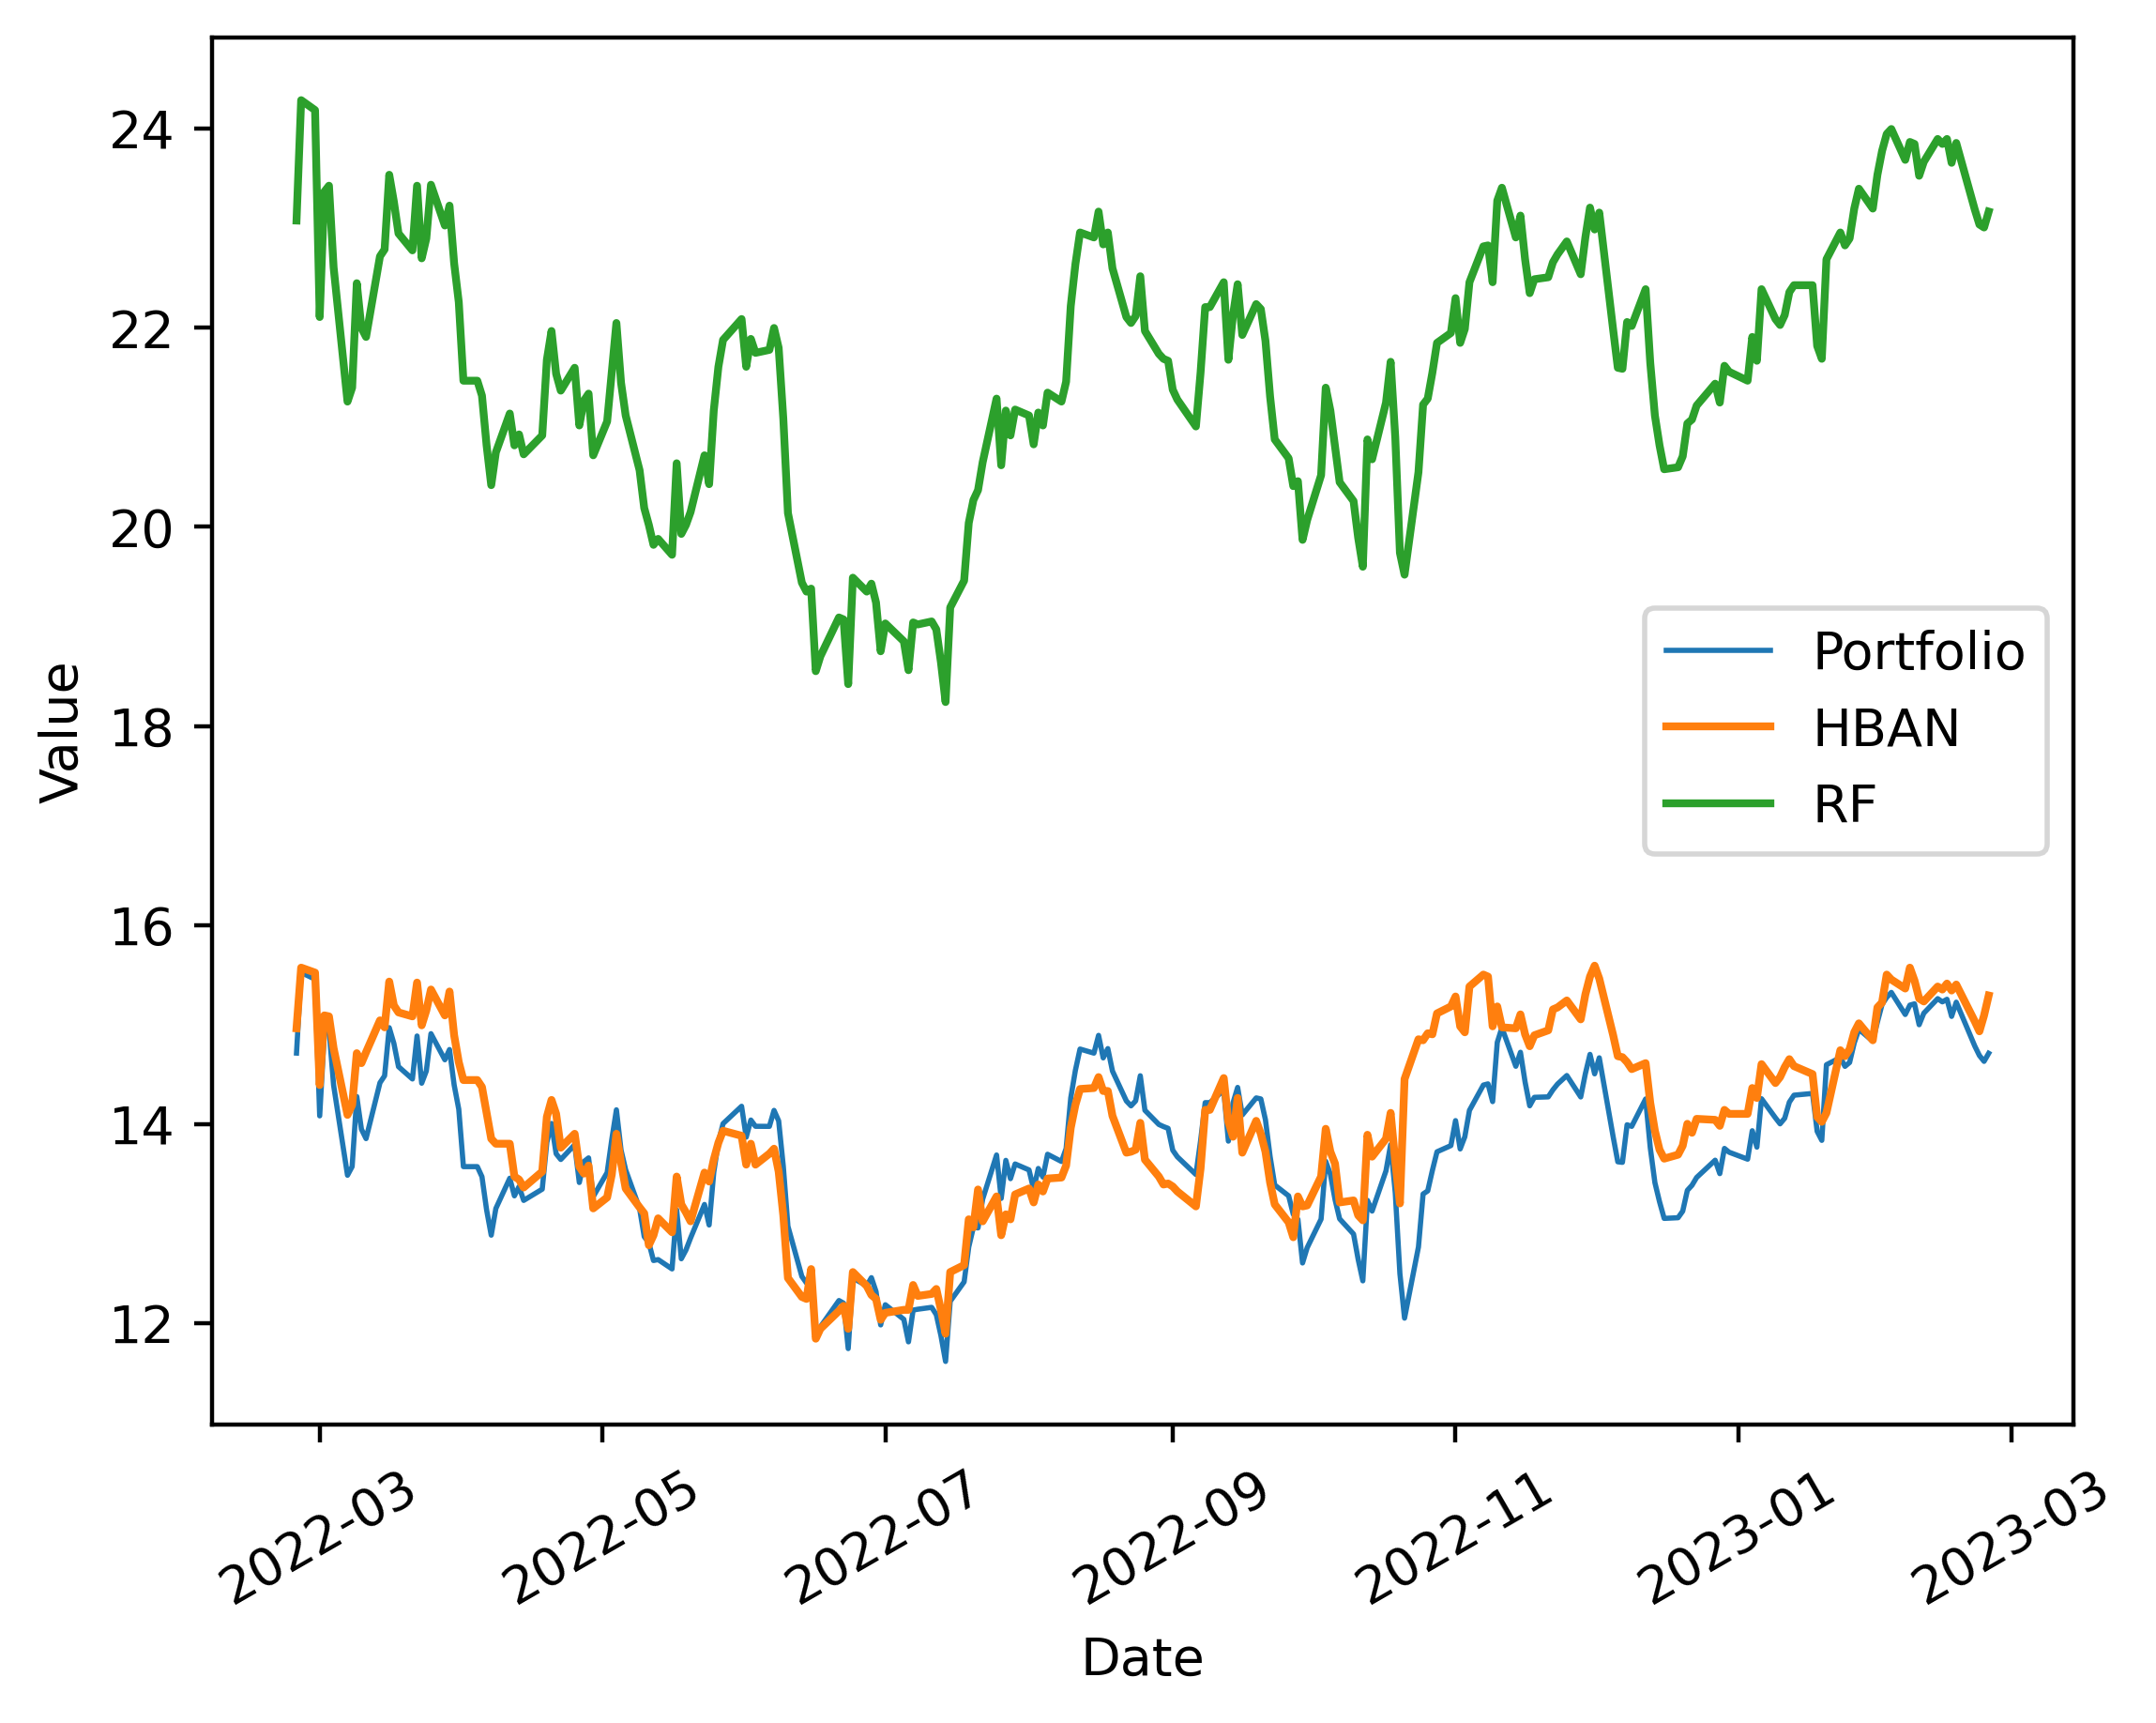

In [113]:
b_alloc2 = stock_1['Close'] * b_alloc / stock_2['Close']
x2 = stock_1['Close'] - b_alloc2 * stock_2['Close']
# x2 = stock_1['Close'] - np.mean(b_alloc2) * stock_2['Close']
plt.figure(dpi=400) 
plt.plot(x2.index, x3.values,linewidth=1)
plt.plot(x2.index, stock_1['Close'])
plt.plot(x2.index, stock_2['Close'])
plt.legend(['Portfolio',stock1_name, stock2_name])
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=30)
plt.show()

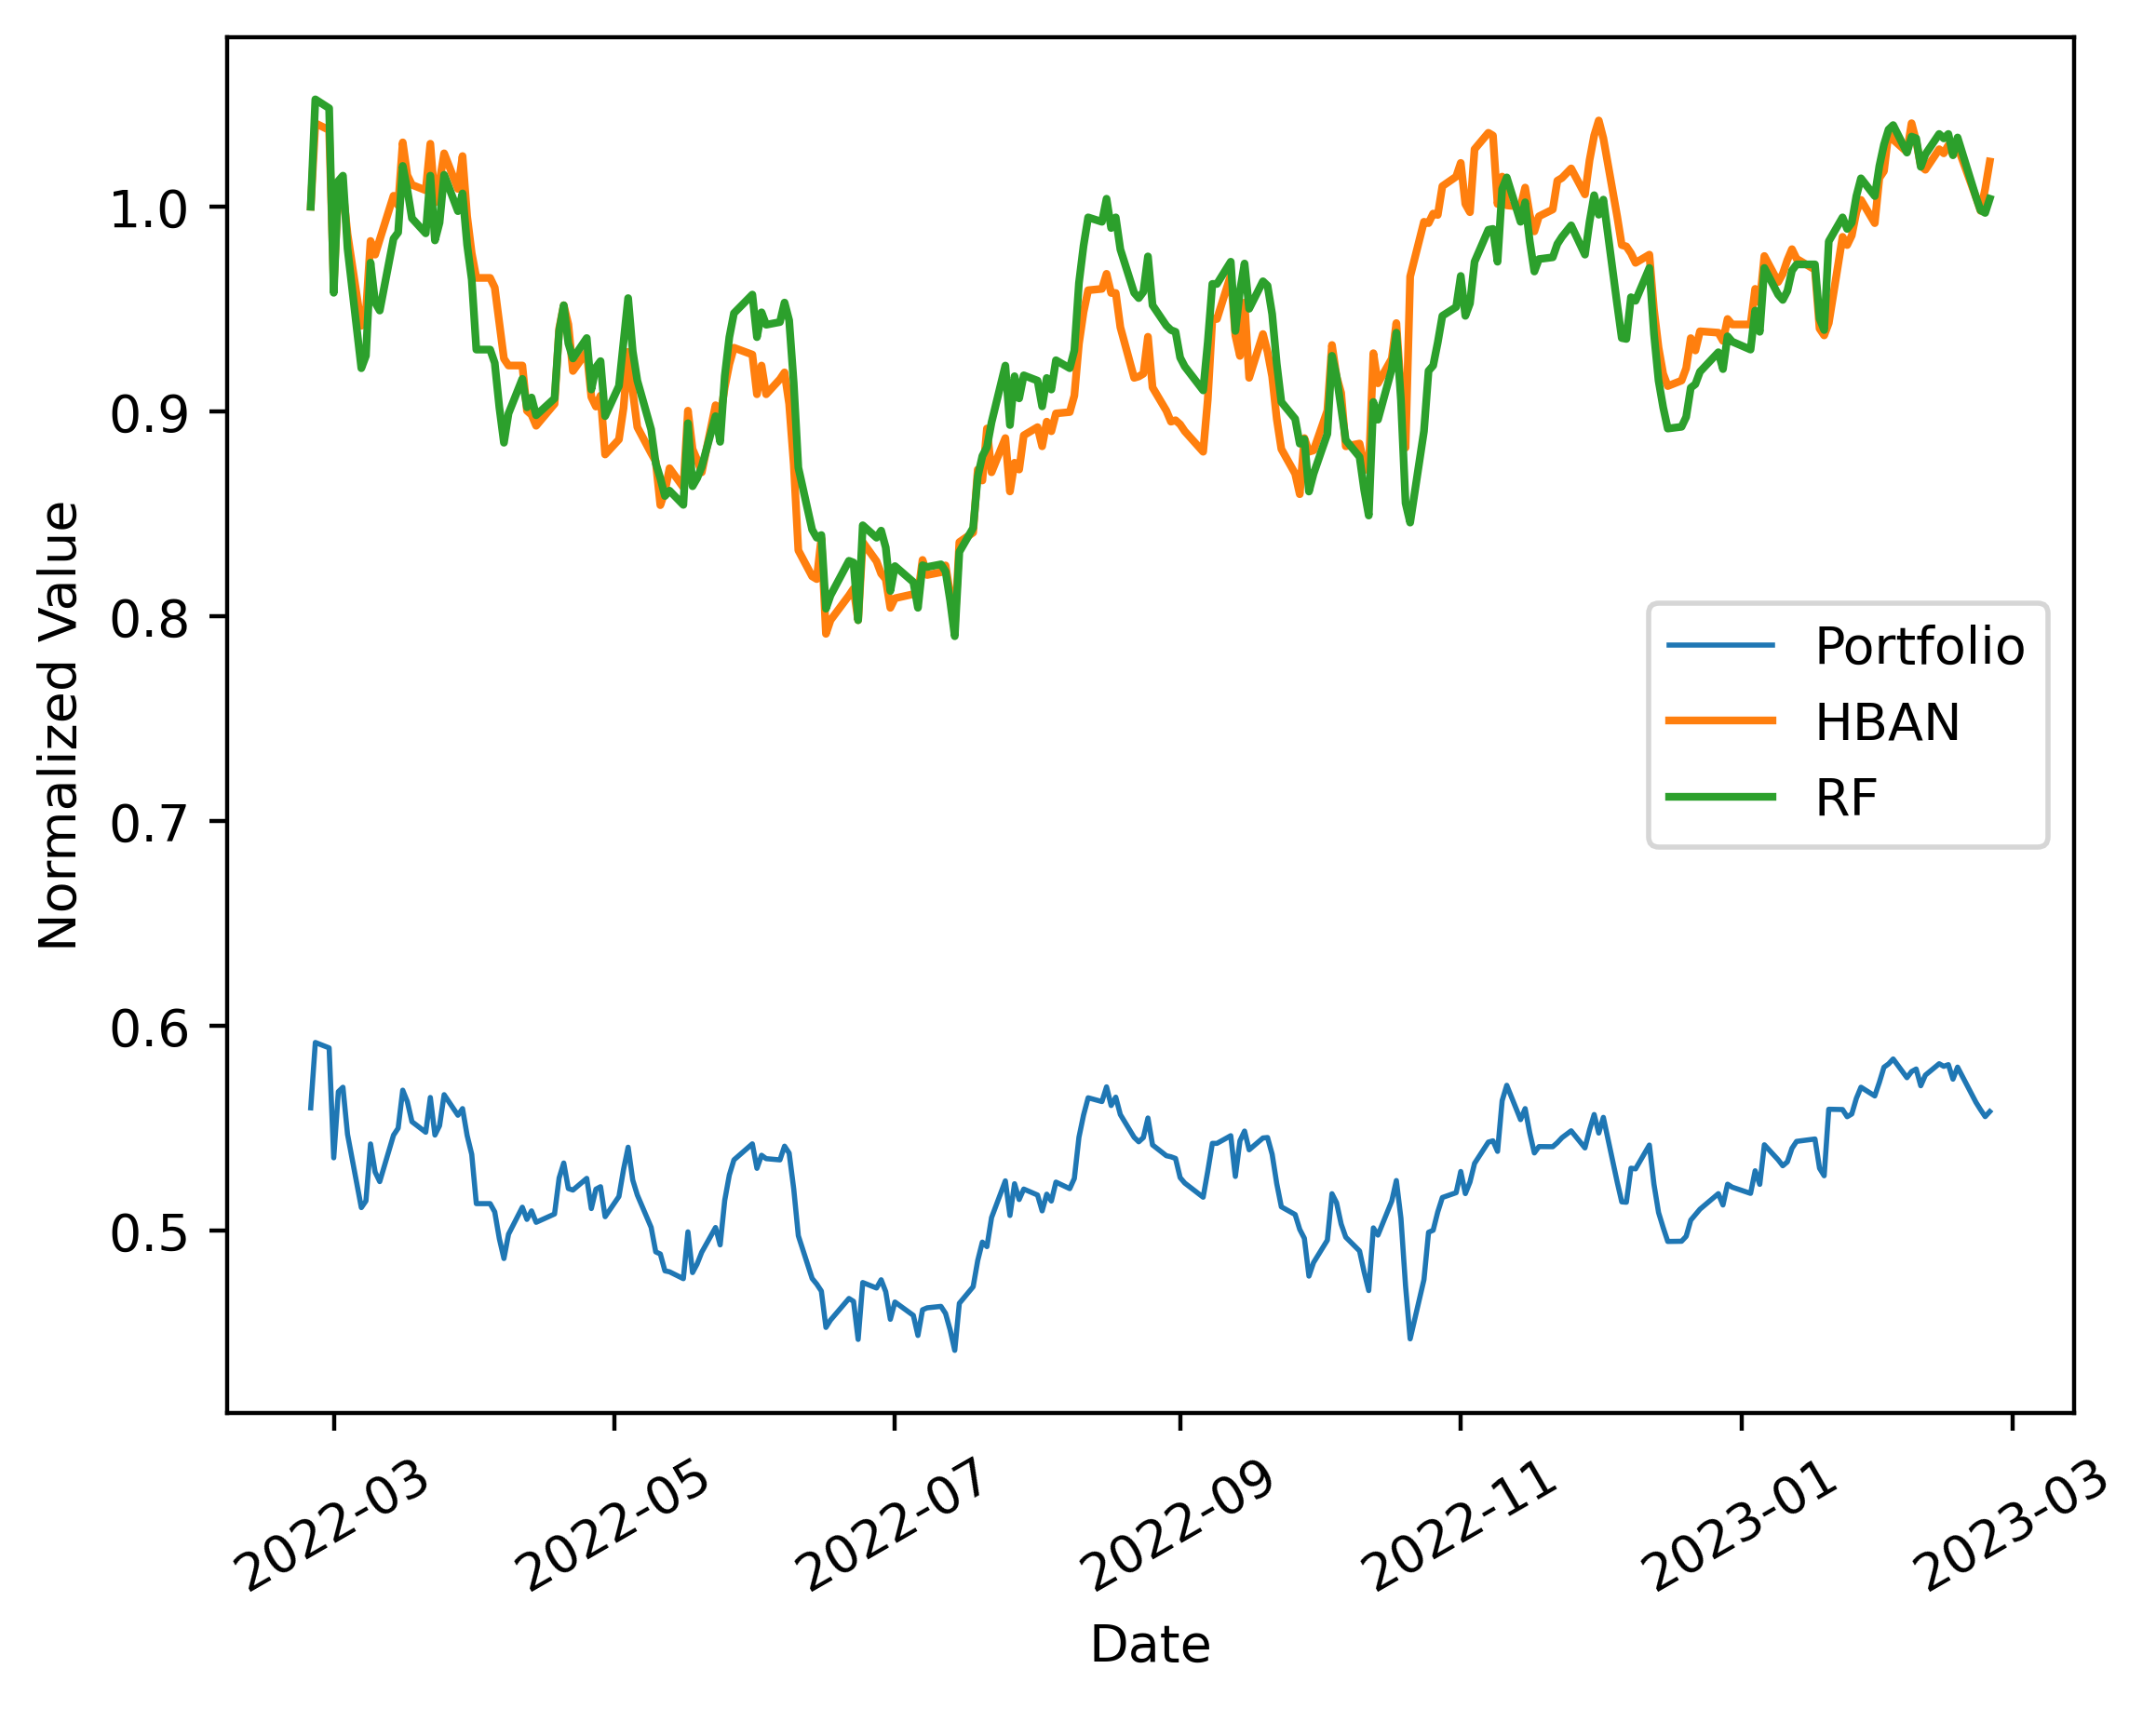

In [114]:
normalized_1 = stock_1['Close']/stock_1['Close'].iloc[0]
normalized_2 = stock_2['Close']/stock_2['Close'].iloc[0]
x4 = (1-b_alloc)*normalized_1 - b_alloc * normalized_2
if b_alloc > (1-b_alloc):
    x4 = -x4
plt.figure(dpi=400) 
plt.plot(x2.index, x4.values,linewidth=1)
plt.plot(x2.index, normalized_1)
plt.plot(x2.index, normalized_2)
plt.legend(['Portfolio',stock1_name, stock2_name])
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.xticks(rotation=30)
plt.show()

In [37]:
temp = x3 / x3[0]
temp

Date
2022-02-24    1.000000
2022-02-25    1.034932
2022-02-28    1.043521
2022-03-01    1.020177
2022-03-02    1.025695
                ...   
2023-02-17    0.943643
2023-02-21    0.933783
2023-02-22    0.932127
2023-02-23    0.926561
2023-02-24    0.921403
Name: Close, Length: 252, dtype: float64

In [58]:
temp = compute_portfolio_values(stock_1['Close'], stock_2['Close'], b_alloc)

<Axes: xlabel='Date'>

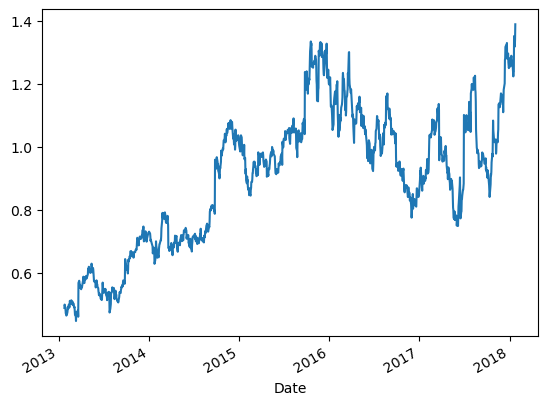

In [59]:
x3 = (1-b_alloc)*stock_1['Close'] - b_alloc * stock_2['Close']

# x3 = (1/stock_1['Close'].iloc[0])*stock_1['Close'] - (b_alloc/stock_2['Close'].iloc[0]) * stock_2['Close']
# x3 = (1*(1-b_alloc)/stock_1['Close'].iloc[0])*stock_1['Close'] - (1*b_alloc/stock_2['Close'].iloc[0]) * stock_2['Close']
if b_alloc > (1-b_alloc):
    x3 = -x3
plt.figure(dpi=400) 
plt.plot(range(1260), x3.values)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Portfolio'])
plt.xticks(rotation=30)
plt.show()

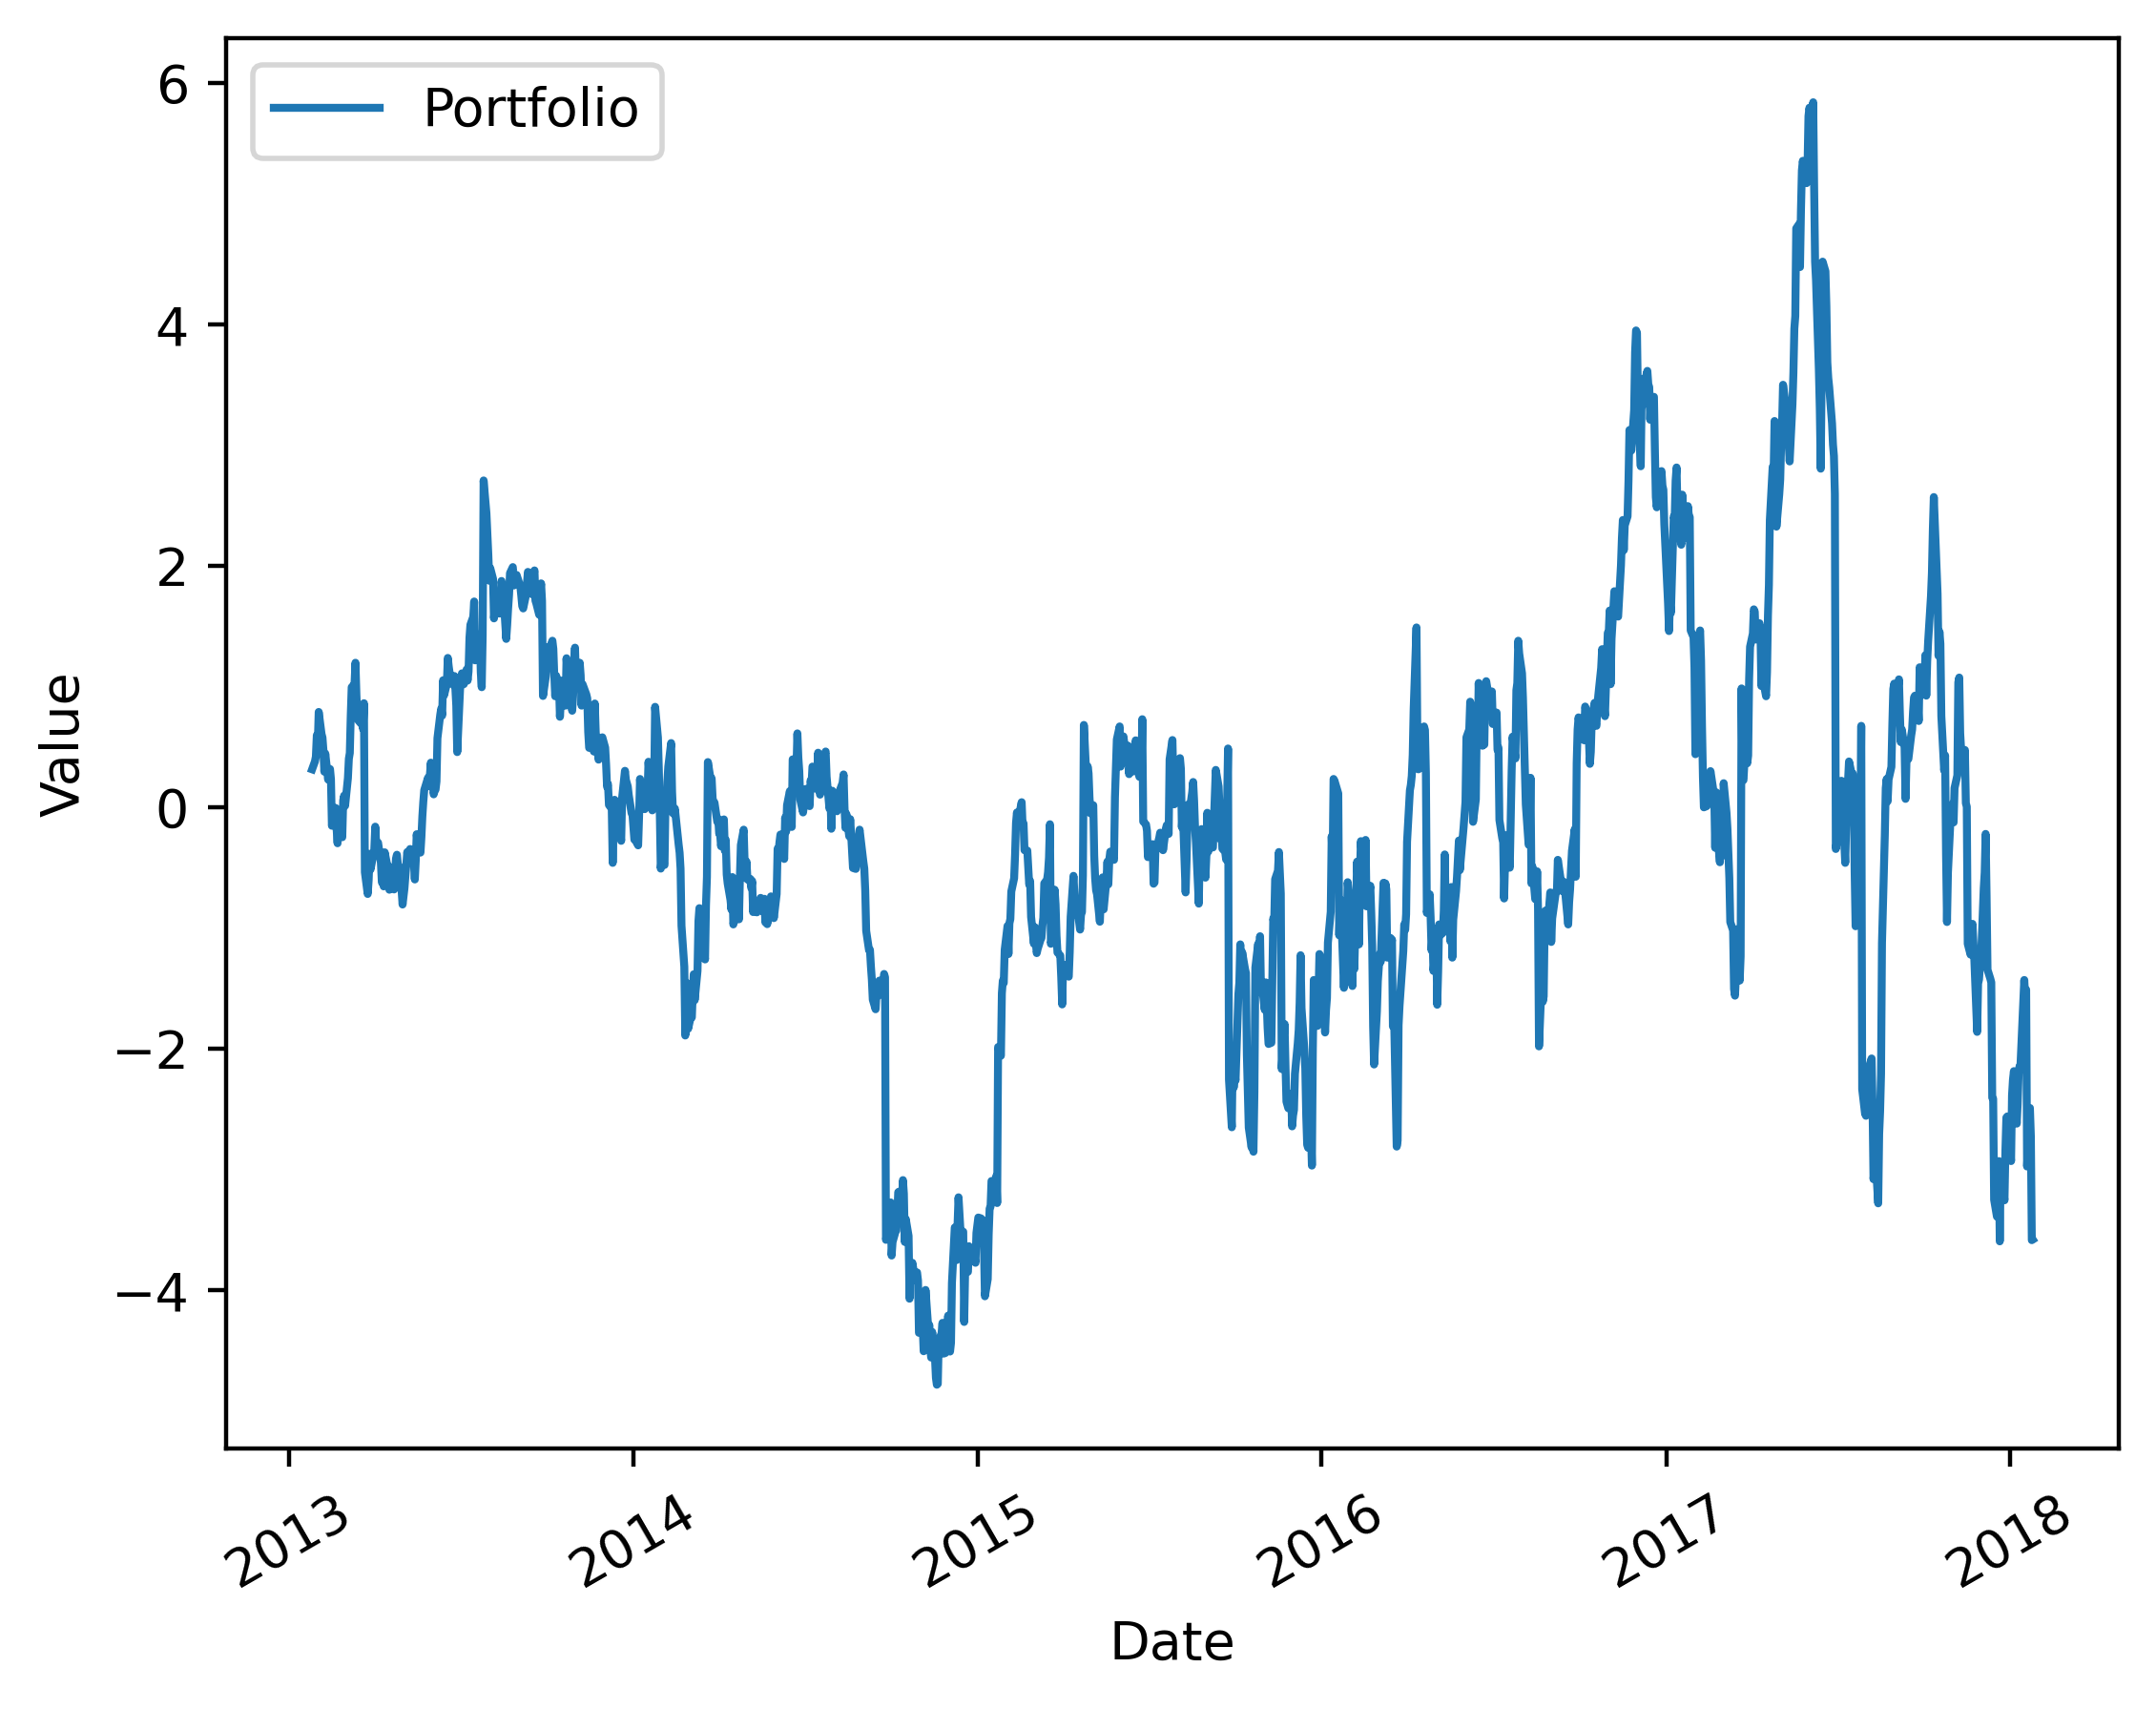

In [138]:
temp = (1/(1+b_alloc))*stock_1['Close'] - (b_alloc/(1+b_alloc))*stock_2['Close']
if (b_alloc/(1+b_alloc)) >= 0.5:
    temp = -temp
plt.figure(dpi=400) 
plt.plot(temp.index, temp.values)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Portfolio'])
plt.xticks(rotation=30)
plt.show()

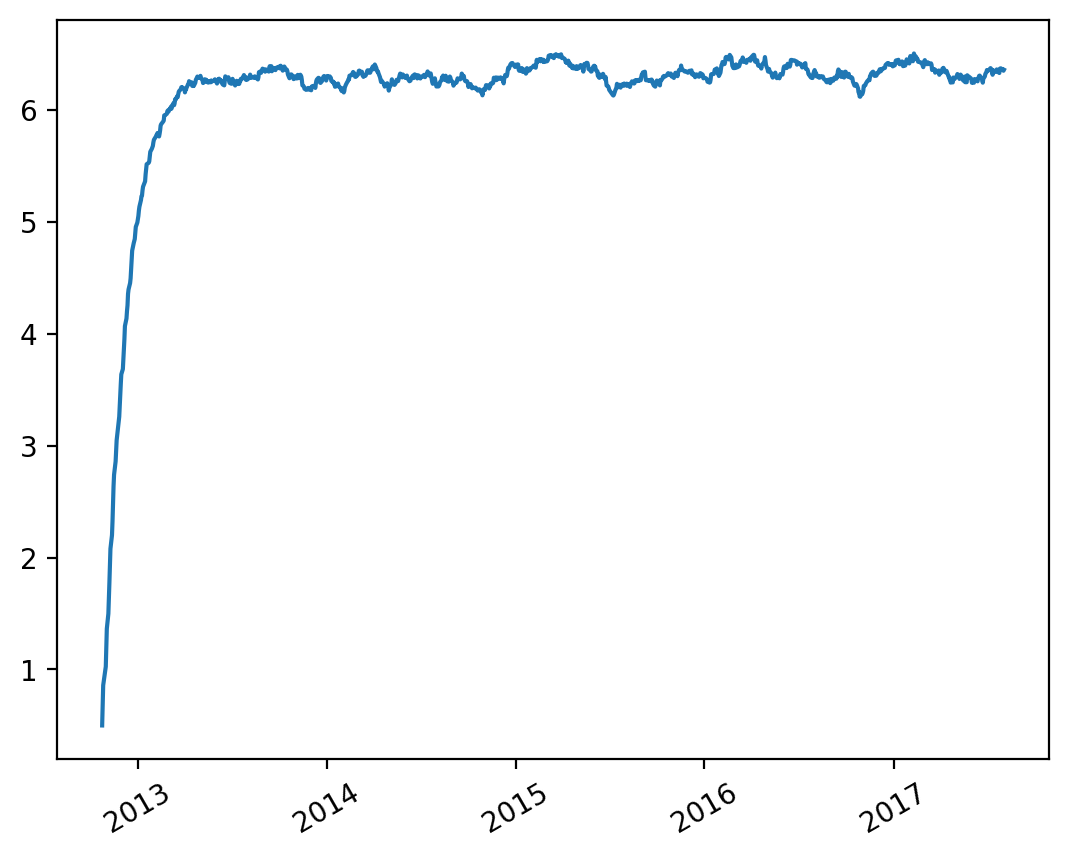

In [128]:
x_ou = [None for i in range(len(x))]
x_ou[0] = x[0]
# theta, mu, sigma, b_alloc
for i in range(len(x)-1):
    x_ou[i+1] = x_ou[i] + theta*(mu - x_ou[i])*np.sqrt(1 / len(x)) + sigma*np.sqrt(1 / len(x))*norm.rvs()
plt.figure(dpi=200) 
plt.plot(x2.index, x_ou)
plt.xticks(rotation=30)
plt.show()

In [153]:
# # Set initial parameter values for optimization
# # params0 = np.array([0.1, np.mean(spread), np.std(spread), initial_weights, 1])
# # params0 = np.array([0.1, np.mean(S*initial_weights), np.std(S*initial_weights), 0.5, -0.5, 1])
# bounds = [None, None, None, (0, 1)]
# constraint_eq1 = {'type': 'eq', 'fun': constraint}
# constraint_ineq2 = {'type': 'ineq', 'fun': constraint2, 'args': (10,)}
# constraints = [constraint_eq1, constraint_ineq2]


# # Perform optimization to find the MLE parameters
# # result = minimize(neg_log_likelihood, params0, args=(S,), method='SLSQP', constraints=constraints)
# result = minimize(neg_log_likelihood3, params0, args=(S,), method='SLSQP', constraints={'fun': constraint3, 'type': 'ineq'})

# # Extract the optimal parameters from the optimization result
# # theta, mu, sigma, a, b, r = result.x
# mu, theta, sigma, beta = result.x

# # Print the optimal parameters
# print('Optimal theta:', theta)
# print('Optimal mu:', mu)
# print('Optimal sigma:', sigma)
# # print('Optimal alpha', a)
# print('Optimal beta:', b)
# # print('Optimal gamma:', r)

/var/folders/q5/pnfmpx1d3tsfl_qtshc9_htw0000gn/T/ipykernel_69102/251260039.py:69: RuntimeWarning: overflow encountered in exp
  sigma_sq_est = sigma_sq*(1-np.exp(-2*mu*delta_t))/(2*mu)
/var/folders/q5/pnfmpx1d3tsfl_qtshc9_htw0000gn/T/ipykernel_69102/251260039.py:72: RuntimeWarning: overflow encountered in exp
  sub = x[i]-x[i-1]*np.exp(-mu*delta_t)-theta*(1-np.exp(-mu*delta_t))
/var/folders/q5/pnfmpx1d3tsfl_qtshc9_htw0000gn/T/ipykernel_69102/251260039.py:72: RuntimeWarning: invalid value encountered in subtract
  sub = x[i]-x[i-1]*np.exp(-mu*delta_t)-theta*(1-np.exp(-mu*delta_t))


Optimal theta: 281.6874151751258
Optimal mu: 0.00977675518160442
Optimal sigma: 0.6283992393329985
Optimal beta: -4644.593497905311


In [154]:
# result.success

False